(parallel)=

# Parallelization

In addition to what\'s in Anaconda, this lecture will need the following
libraries:

In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in /usr/share/miniconda3/envs/qe-example/lib/python3.7/site-packages (0.4.8)


## Overview

The growth of CPU clock speed (i.e., the speed at which a single chain
of logic can be run) has slowed dramatically in recent years.

This is unlikely to change in the near future, due to inherent physical
limitations on the construction of chips and circuit boards.

Chip designers and computer programmers have responded to the slowdown
by seeking a different path to fast execution: parallelization.

Hardware makers have increased the number of cores (physical CPUs)
embedded in each machine.

For programmers, the challenge has been to exploit these multiple CPUs
by running many processes in parallel (i.e., simultaneously).

This is particularly important in scientific programming, which requires
handling

-   large amounts of data and
-   CPU intensive simulations and other calculations.

In this lecture we discuss parallelization for scientific computing,
with a focus on

1.  the best tools for parallelization in Python and
2.  how these tools can be applied to quantitative economic problems.

Let\'s start with some imports:

In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

%matplotlib inline

/usr/share/miniconda3/envs/qe-example/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Types of Parallelization

Large textbooks have been written on different approaches to
parallelization but we will keep a tight focus on what\'s most useful to
us.

We will briefly review the two main kinds of parallelization commonly
used in scientific computing and discuss their pros and cons.

### Multiprocessing

Multiprocessing means concurrent execution of multiple processes using
more than one processor.

In this context, a **process** is a chain of instructions (i.e., a
program).

Multiprocessing can be carried out on one machine with multiple CPUs or
on a collection of machines connected by a network.

In the latter case, the collection of machines is usually called a
**cluster**.

With multiprocessing, each process has its own memory space, although
the physical memory chip might be shared.

### Multithreading

Multithreading is similar to multiprocessing, except that, during
execution, the threads all share the same memory space.

Native Python struggles to implement multithreading due to some [legacy
design features](https://wiki.python.org/moin/GlobalInterpreterLock).

But this is not a restriction for scientific libraries like NumPy and
Numba.

Functions imported from these libraries and JIT-compiled code run in low
level execution environments where Python\'s legacy restrictions don\'t
apply.

### Advantages and Disadvantages

Multithreading is more lightweight because most system and memory
resources are shared by the threads.

In addition, the fact that multiple threads all access a shared pool of
memory is extremely convenient for numerical programming.

On the other hand, multiprocessing is more flexible and can be
distributed across clusters.

For the great majority of what we do in these lectures, multithreading
will suffice.

## Implicit Multithreading in NumPy

Actually, you have already been using multithreading in your Python
code, although you might not have realized it.

(We are, as usual, assuming that you are running the latest version of
Anaconda Python.)

This is because NumPy cleverly implements multithreading in a lot of its
compiled code.

Let\'s look at some examples to see this in action.

### A Matrix Operation

The next piece of code computes the eigenvalues of a large number of
randomly generated matrices.

It takes a few seconds to run.

In [3]:
n = 20
m = 1000
for i in range(n):
    X = np.random.randn(m, m)
    λ = np.linalg.eigvals(X)

Now, let\'s look at the output of the `htop` system monitor
on our machine while this code is running:

```{figure} /_static/lecture_specific/parallelization/htop_parallel_npmat.png
:scale: 65%
```

We can see that 4 of the 8 CPUs are running at full speed.

This is because NumPy\'s `eigvals` routine neatly splits up the tasks
and distributes them to different threads.

### A Multithreaded Ufunc

Over the last few years, NumPy has managed to push this kind of
multithreading out to more and more operations.

For example, let\'s return to a maximization problem
{ref}`discussed previously <ufuncs>`:

In [4]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 5000)
x, y = np.meshgrid(grid, grid)

In [5]:
%timeit np.max(f(x, y))

1.08 s ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If you have a system monitor such as `htop` (Linux/Mac) or
`perfmon` (Windows), then try running this and then
observing the load on your CPUs.

(You will probably need to bump up the grid size to see large effects.)

At least on our machine, the output shows that the operation is
successfully distributed across multiple threads.

This is one of the reasons why the vectorized code above is fast.

### A Comparison with Numba

To get some basis for comparison for the last example, let\'s try the
same thing with Numba.

In fact there is an easy way to do this, since Numba can also be used to
create custom {ref}`ufuncs <ufuncs>` with the
[@vectorize](http://numba.pydata.org/numba-doc/dev/user/vectorize.html)
decorator.

In [6]:
from numba import vectorize

@vectorize
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y))  # Run once to compile

0.9999992797121728

In [7]:
%timeit np.max(f_vec(x, y))

632 ms ± 8.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


At least on our machine, the difference in the speed between the Numba
version and the vectorized NumPy version shown above is not large.

But there\'s quite a bit going on here so let\'s try to break down what
is happening.

Both Numba and NumPy use efficient machine code that\'s specialized to
these floating point operations.

However, the code NumPy uses is, in some ways, less efficient.

The reason is that, in NumPy, the operation
`np.cos(x**2 + y**2) / (1 + x**2 + y**2)` generates several intermediate
arrays.

For example, a new array is created when `x**2` is calculated.

The same is true when `y**2` is calculated, and then `x**2 + y**2` and
so on.

Numba avoids creating all these intermediate arrays by compiling one
function that is specialized to the entire operation.

But if this is true, then why isn\'t the Numba code faster?

The reason is that NumPy makes up for its disadvantages with implicit
multithreading, as we\'ve just discussed.

### Multithreading a Numba Ufunc

Can we get both of these advantages at once?

In other words, can we pair

-   the efficiency of Numba\'s highly specialized JIT compiled function
    and
-   the speed gains from parallelization obtained by NumPy\'s implicit
    multithreading?

It turns out that we can, by adding some type information plus
`target='parallel'`.

In [8]:
@vectorize('float64(float64, float64)', target='parallel')
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y))  # Run once to compile

0.9999992797121728

In [9]:
%timeit np.max(f_vec(x, y))

524 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now our code runs significantly faster than the NumPy version.

## Multithreaded Loops in Numba

We just saw one approach to parallelization in Numba, using the
`parallel` flag in `@vectorize`.

This is neat but, it turns out, not well suited to many problems we
consider.

Fortunately, Numba provides another approach to multithreading that will
work for us almost everywhere parallelization is possible.

To illustrate, let\'s look first at a simple, single-threaded (i.e.,
non-parallelized) piece of code.

The code simulates updating the wealth $w_t$ of a household via the rule

$$
w_{t+1} = R_{t+1} s w_t + y_{t+1}
$$

Here

-   $R$ is the gross rate of return on assets
-   $s$ is the savings rate of the household and
-   $y$ is labor income.

We model both $R$ and $y$ as independent draws from a lognormal
distribution.

Here\'s the code:

In [10]:
from numpy.random import randn
from numba import njit

@njit
def h(w, r=0.1, s=0.3, v1=0.1, v2=1.0):
    """
    Updates household wealth.
    """

    # Draw shocks
    R = np.exp(v1 * randn()) * (1 + r)
    y = np.exp(v2 * randn())

    # Update wealth
    w = R * s * w + y
    return w

Let\'s have a look at how wealth evolves under this rule.

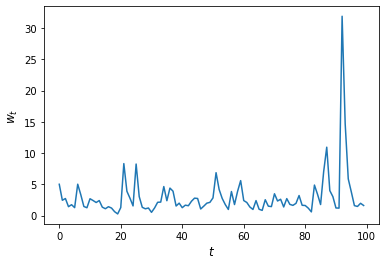

In [11]:
fig, ax = plt.subplots()

T = 100
w = np.empty(T)
w[0] = 5
for t in range(T-1):
    w[t+1] = h(w[t])

ax.plot(w)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$w_{t}$', fontsize=12)
plt.show()

Now let\'s suppose that we have a large population of households and we
want to know what median wealth will be.

This is not easy to solve with pencil and paper, so we will use
simulation instead.

In particular, we will simulate a large number of households and then
calculate median wealth for this group.

Suppose we are interested in the long-run average of this median over
time.

It turns out that, for the specification that we\'ve chosen above, we
can calculate this by taking a one-period snapshot of what has happened
to median wealth of the group at the end of a long simulation.

Moreover, provided the simulation period is long enough, initial
conditions don\'t matter.

-   This is due to something called ergodicity, which we will discuss [later on](https://python-intro.quantecon.org/finite_markov.html#Ergodicity).

So, in summary, we are going to simulate 50,000 households by

1.  arbitrarily setting initial wealth to 1 and
2.  simulating forward in time for 1,000 periods.

Then we\'ll calculate median wealth at the end period.

Here\'s the code:

In [12]:
@njit
def compute_long_run_median(w0=1, T=1000, num_reps=50_000):

    obs = np.empty(num_reps)
    for i in range(num_reps):
        w = w0
        for t in range(T):
            w = h(w)
        obs[i] = w

    return np.median(obs)

Let\'s see how fast this runs:

In [13]:
%%time
compute_long_run_median()

CPU times: user 8.92 s, sys: 17.7 ms, total: 8.93 s
Wall time: 8.89 s


1.8282418988967082

To speed this up, we\'re going to parallelize it via multithreading.

To do so, we add the `parallel=True` flag and change `range` to
`prange`:

In [14]:
from numba import prange

@njit(parallel=True)
def compute_long_run_median_parallel(w0=1, T=1000, num_reps=50_000):

    obs = np.empty(num_reps)
    for i in prange(num_reps):
        w = w0
        for t in range(T):
            w = h(w)
        obs[i] = w

    return np.median(obs)

Let\'s look at the timing:

In [15]:
%%time
compute_long_run_median_parallel()

CPU times: user 8.3 s, sys: 1.11 ms, total: 8.3 s
Wall time: 4.52 s


1.8194926387845551

The speed-up is significant.

### A Warning

Parallelization works well in the outer loop of the last example because
the individual tasks inside the loop are independent of each other.

If this independence fails then parallelization is often problematic.

For example, each step inside the inner loop depends on the last step,
so independence fails, and this is why we use ordinary `range` instead
of `prange`.

When you see us using `prange` in later lectures, it is because the
independence of tasks holds true.

When you see us using ordinary `range` in a jitted function, it is
either because the speed gain from parallelization is small or because
independence fails.

## Exercises

### Exercise 1

In {ref}`an earlier exercise <speed_ex1>`, we
used Numba to accelerate an effort to compute the constant $\pi$ by
Monte Carlo.

Now try adding parallelization and see if you get further speed gains.

You should not expect huge gains here because, while there are many
independent tasks (draw point and test if in circle), each one has low
execution time.

Generally speaking, parallelization is less effective when the
individual tasks to be parallelized are very small relative to total
execution time.

This is due to overheads associated with spreading all of these small
tasks across multiple CPUs.

Nevertheless, with suitable hardware, it is possible to get nontrivial
speed gains in this exercise.

For the size of the Monte Carlo simulation, use something substantial,
such as `n = 100_000_000`.

## Solutions

### Exercise 1

Here is one solution:

In [16]:
from random import uniform

@njit(parallel=True)
def calculate_pi(n=1_000_000):
    count = 0
    for i in prange(n):
        u, v = uniform(0, 1), uniform(0, 1)
        d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
        if d < 0.5:
            count += 1

    area_estimate = count / n
    return area_estimate * 4  # dividing by radius**2

Now let\'s see how fast it runs:

In [17]:
%time calculate_pi()

CPU times: user 421 ms, sys: 142 µs, total: 421 ms
Wall time: 414 ms


3.140896

In [18]:
%time calculate_pi()

CPU times: user 17.9 ms, sys: 332 µs, total: 18.3 ms
Wall time: 10.4 ms


3.142876

By switching parallelization on and off (selecting `True` or `False` in
the `@njit` annotation), we can test the speed gain that multithreading
provides on top of JIT compilation.

On our workstation, we find that parallelization increases execution
speed by a factor of 2 or 3.

(If you are executing locally, you will get different numbers, depending
mainly on the number of CPUs on your machine.)